In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

train = pd.read_csv('train.csv')

In [3]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
male_age_avg = train[train['Sex']=='male']['Age'].mean()
male_age_std = train[train['Sex']=='male']['Age'].std()
female_age_avg = train[train['Sex']=='female']['Age'].mean()
female_age_std = train[train['Sex']=='female']['Age'].std()

aaa = train[train.Sex=='male']
aaa['Age'].fillna(np.random.randint(male_age_avg - male_age_std, male_age_avg + male_age_std), inplace=True)
#aaa.info()
bbb = train[train.Sex=='female']
bbb['Age'].fillna(np.random.randint(female_age_avg - male_age_std, male_age_avg + male_age_std), inplace=True)
#bbb.info()
train = pd.concat([aaa, bbb], axis=0)

/home/toshiya/.local/share/virtualenvs/chainertest-bE9YSNyU/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


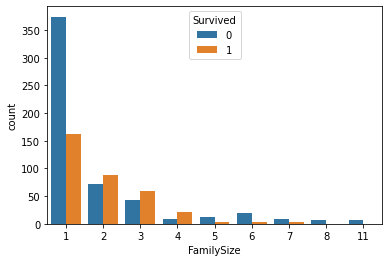

In [5]:
train['FamilySize'] = train['Parch'] + train['SibSp'] + 1
train['FamilySize'] = train['FamilySize'][:len(train)]
#test['FamilySize'] = train['FamilySize'][len(train):]
sns.countplot(x='FamilySize', data=train, hue='Survived')

train['IsAlone'] = 0
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1
train['IsAlone'] = train['IsAlone'][:len(train)]


In [6]:
from sklearn.model_selection import train_test_split
# 欠損値処理
train['Fare'] = train['Fare'].fillna(train['Fare'].median())
#train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna('S')

# カテゴリ変数の変換
train['Sex'] = train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
train['Embarked'] = train['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)

# 不要なColumnsを削除
train = train.drop(['Cabin', 'Name', 'PassengerId', 'Ticket', 'SibSp', 'Parch'], axis=1)

In [7]:
from chainer import datasets, iterators

data_array = train.values

X = []
Y = []
for x in data_array:
    #x_split = np.hsplit(x, [3,4])
    x_split = np.hsplit(x, [1])
    X.append(x_split[1].astype(np.float32))
    Y.append(x_split[0].astype(np.int32))

X = np.array(X)
Y = np.ndarray.flatten(np.array(Y))

train_X, test = datasets.split_dataset_random(datasets.TupleDataset(X, Y), 623)
train_iter = iterators.SerialIterator(train_X, batch_size=100, shuffle=True)
test_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import chainer

from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
%matplotlib inline

class DNN(Chain):
    def __init__(self, n_mid_units=200, n_out=2):
        super(DNN, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)
 
    #def forward(self, x):
    def __call__(self, x):
        h1 = F.selu(self.l1(x))
        h2 = F.selu(self.l2(h1))
        y = self.l3(h2)
        return y

gpu_id = 0

model = DNN()
if gpu_id >= 0:
    model.to_gpu(gpu_id)

In [9]:
nn = DNN()
model = L.Classifier(nn)

if gpu_id >= 0:
    model.to_gpu(gpu_id)


optimizer = optimizers.Adam()
optimizer.setup(model)
 
updater = training.StandardUpdater(train_iter, optimizer)

trainer = training.Trainer(updater, (500, 'epoch'), out="result")
#trainer = training.Trainer(updater, (100, 'iteration'), out="result")

#trainer.extend(extensions.LogReport())
trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='log'))
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.Evaluator(test_iter, model))
#trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy']))
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'fc1/W/data/mean', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['fc1/W/grad/mean'], x_key='epoch', file_name='mean.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.ParameterStatistics(model.predictor.l1, {'mean': np.mean}, report_grads=True))
trainer.extend(extensions.ProgressBar())
trainer.run()

Exception in main training loop: incompatible array types are mixed in the forward input (LinearFunction).
Actual: <class 'numpy.ndarray'>, <class 'cupy.core.core.ndarray'>, <class 'cupy.core.core.ndarray'>
Traceback (most recent call last):
  File "/home/toshiya/.local/share/virtualenvs/chainertest-bE9YSNyU/lib/python3.7/site-packages/chainer/training/trainer.py", line 343, in run
    update()
  File "/home/toshiya/.local/share/virtualenvs/chainertest-bE9YSNyU/lib/python3.7/site-packages/chainer/training/updaters/standard_updater.py", line 240, in update
    self.update_core()
  File "/home/toshiya/.local/share/virtualenvs/chainertest-bE9YSNyU/lib/python3.7/site-packages/chainer/training/updaters/standard_updater.py", line 253, in update_core
    optimizer.update(loss_func, *in_arrays)
  File "/home/toshiya/.local/share/virtualenvs/chainertest-bE9YSNyU/lib/python3.7/site-packages/chainer/optimizer.py", line 874, in update
    loss = lossfun(*args, **kwds)
  File "/home/toshiya/.local/

TypeError: incompatible array types are mixed in the forward input (LinearFunction).
Actual: <class 'numpy.ndarray'>, <class 'cupy.core.core.ndarray'>, <class 'cupy.core.core.ndarray'>

In [26]:
#テスト
#
df_test = pd.read_csv('test.csv')
#df_test.head()

#df_test['FamilySize'] = df_test['FamilySize'][len(train):]
#df_test['IsAlone'] = df_test['IsAlone'][len(train):]
df_test['FamilySize'] = df_test['Parch'] + df_test['SibSp'] + 1
df_test['IsAlone'] = 0
df_test.loc[df_test['FamilySize'] == 1, 'IsAlone'] = 1
df_test['IsAlone'] = df_test['IsAlone'][:len(df_test)]

passsengerid = df_test['PassengerId']
df_test.isnull().sum()
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].median())

#df_test['Age'] = df_test['Age'].fillna(df_test['Age'].median())
df_test_male = df_test[df_test.Sex=='male']
df_test_male['Age'].fillna(np.random.randint(male_age_avg - male_age_std, male_age_avg + male_age_std), inplace=True)
df_test_female = df_test[df_test.Sex=='female']
df_test_female['Age'].fillna(np.random.randint(female_age_avg - male_age_std, male_age_avg + male_age_std), inplace=True)
#bbb.info()
df_test = pd.concat([df_test_male, df_test_female], axis=0)

df_test['Embarked'] = df_test['Embarked'].fillna('S')

#カテゴリ変数の変換
df_test['Sex'] = df_test['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df_test['Embarked'] = df_test['Embarked'].map( {'S': 0 , 'C':1 , 'Q':2}).astype(int)

#不要なcolumnを削除
df_test_exe= df_test.drop(['Cabin','Name','Ticket', 'SibSp', 'Parch'],axis =1)
df_test= df_test_exe.drop(['PassengerId'],axis =1)

/home/toshiya/.local/share/virtualenvs/chainertest-bE9YSNyU/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


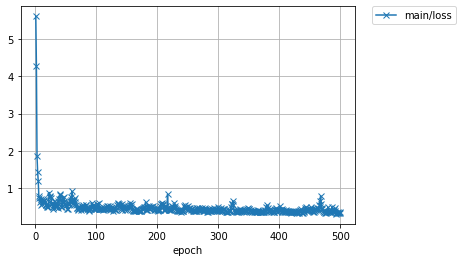

In [27]:
# ロスのグラフ
from IPython.display import Image
Image(filename='result/loss.png')

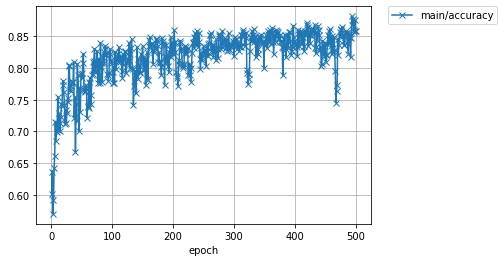

In [28]:
# 精度のグラフ
Image(filename='result/accuracy.png')

In [29]:
!dot -Tpng result/cg.dot -o result/cg.png

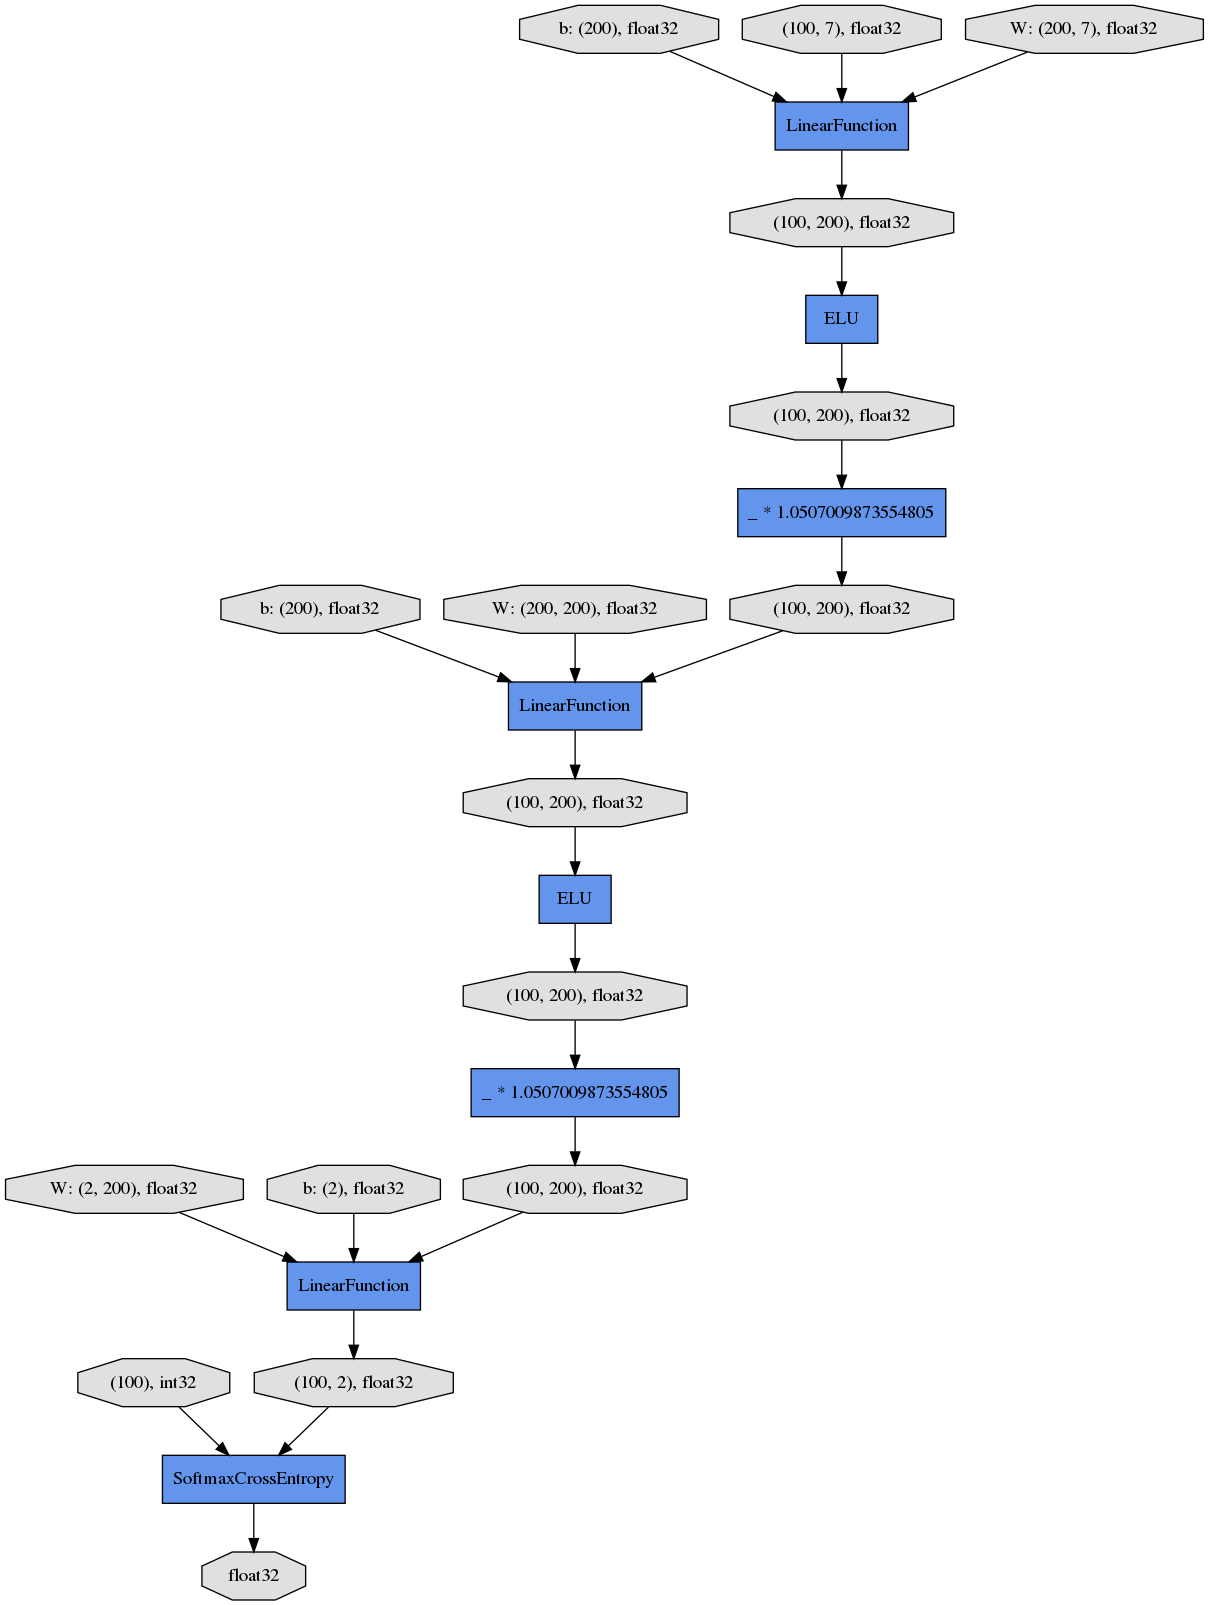

In [30]:
Image(filename='result/cg.png')

In [13]:
result = nn(df_test.astype(np.float32).values)
#print(result.data)
result = [np.argmax(x) for x in result.data]
submission = pd.DataFrame({
    'PassengerId': df_test_exe["PassengerId"],
    'Survived': result
})
submission.to_csv('submission.csv', index=False)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x_train = pd.read_csv('train.csv')

null_columns=x_train.columns[x_train.isnull().any()]
print("NULL COLUMNS OF YOUR DATAFRAME : " , null_columns , '\n')

y_train = x_train.iloc[: , 1].values
print(y_train)

x_train = x_train.drop(["PassengerId" , "Survived" , "Name" , "Ticket" , "Cabin"] , axis = 1)
print(x_train)

NULL COLUMNS OF YOUR DATAFRAME :  Index(['Age', 'Cabin', 'Embarked'], dtype='object') 


[0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0
 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1
 1 1 1 1 1 

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
x_train = np.array(ct.fit_transform(x_train))

print("Column Number = 0 : " , x_train[: , 0])
print("Column Number = 1 : " , x_train[: , 1])
print("Column Number = 2 : " , x_train[: , 2])

Column Number = 0 :  [0.0 1.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0
 1.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0
 0.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0
 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

In [4]:
# FILLING MISSING VALUES USING MODE STRATEGY
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
x_train[: , 3] = imputer.fit_transform(x_train[: , 3].reshape(- 1 , 1)).reshape(-1)


# LABEL ENCODING
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
label_encoder_x = LabelEncoder()
x_train[: , 3] = label_encoder_x.fit_transform(x_train[: , 3])

# ONE HOT ENCODING
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers = [ ('encoder' , OneHotEncoder() , [3]) ] , remainder = 'passthrough')
x_train = np.array(  ct.fit_transform(x_train)  )


print("Column Number = 3 : " , x_train[: , 3])
print("Column Number = 4 : " , x_train[: , 4])

Column Number = 3 :  [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0
 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0
 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 1.0 1.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 1.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0
 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0
 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0
 0.0 1.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0
 1.0 0.0 1.0 1.0 1.0 1.0 0.0 0

In [5]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'mean')
x_train[: , 5] = imputer.fit_transform(x_train[: , 5].reshape(-1 , 1)).reshape(-1)

print(x_train[: , 5])

[22.0 38.0 26.0 35.0 35.0 29.69911764705882 54.0 2.0 27.0 14.0 4.0 58.0
 20.0 39.0 14.0 55.0 2.0 29.69911764705882 31.0 29.69911764705882 35.0
 34.0 15.0 28.0 8.0 38.0 29.69911764705882 19.0 29.69911764705882
 29.69911764705882 40.0 29.69911764705882 29.69911764705882 66.0 28.0 42.0
 29.69911764705882 21.0 18.0 14.0 40.0 27.0 29.69911764705882 3.0 19.0
 29.69911764705882 29.69911764705882 29.69911764705882 29.69911764705882
 18.0 7.0 21.0 49.0 29.0 65.0 29.69911764705882 21.0 28.5 5.0 11.0 22.0
 38.0 45.0 4.0 29.69911764705882 29.69911764705882 29.0 19.0 17.0 26.0
 32.0 16.0 21.0 26.0 32.0 25.0 29.69911764705882 29.69911764705882 0.83
 30.0 22.0 29.0 29.69911764705882 28.0 17.0 33.0 16.0 29.69911764705882
 23.0 24.0 29.0 20.0 46.0 26.0 59.0 29.69911764705882 71.0 23.0 34.0 34.0
 28.0 29.69911764705882 21.0 33.0 37.0 28.0 21.0 29.69911764705882 38.0
 29.69911764705882 47.0 14.5 22.0 20.0 17.0 21.0 70.5 29.0 24.0 2.0 21.0
 29.69911764705882 32.5 32.5 54.0 12.0 29.69911764705882 24.0
 29.

In [6]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
x_train[: , -1] = imputer.fit_transform(x_train[: , -1].reshape(-1 , 1)).reshape(891)

from sklearn.preprocessing import LabelEncoder , OneHotEncoder
label_encoder_x = LabelEncoder()
x_train[: , -1] = label_encoder_x.fit_transform(x_train[: , -1])

from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers = [ ('encoder' , OneHotEncoder() , [-1] ) ] , remainder = 'passthrough')
x_train = np.array(ct.fit_transform(x_train))

In [7]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 15, metric = 'minkowski', p = 2)
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [10]:
x_test = pd.read_csv('test.csv')

# PassengerId columns
passenger_id_col = np.array(x_test['PassengerId']).reshape(-1 , 1)

null_columns=x_test.columns[x_test.isnull().any()]
print("NULL COLUMNS OF YOUR DATAFRAME : " , null_columns , '\n\n')

x_test = x_test.drop(["PassengerId" , "Name" , "Ticket" , "Cabin"] , axis = 1)

# PassengerId columns

print(type(x_test))

NULL COLUMNS OF YOUR DATAFRAME :  Index(['Age', 'Fare', 'Cabin'], dtype='object') 


<class 'pandas.core.frame.DataFrame'>


In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


ct = ColumnTransformer(transformers = [ ('encoder' , OneHotEncoder() , [0]) ] , remainder = "passthrough")
x_test = np.array(ct.fit_transform(x_test))
print(x_test[: , 0])

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0
 0.0 0.0 1.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0
 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 0.0 1.0
 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0
 0.0 1.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0
 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0
 0.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0
 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0
 1.0 0.0 1.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0 0.0 1.0 0.

In [12]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
label_encoder_x = LabelEncoder()
x_test[: , 3] = label_encoder_x.fit_transform(x_test[: , 3])


from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers = [ ('encoder' , OneHotEncoder() , [3]) ] , remainder = 'passthrough')
x_test = np.array(ct.fit_transform(x_test))

print(x_test[: , 3])

[0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 1.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0
 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0
 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0
 1.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0
 1.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0
 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.

In [13]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
x_test[: , 5] = imputer.fit_transform(x_test[: , 5].reshape(-1 , 1)).reshape(-1)

In [14]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'mean')
x_test[: , -2] = imputer.fit_transform(x_test[: , -2].reshape(-1 , 1)).reshape(-1)

print(x_test[ : , -2])

[7.8292 7.0 9.6875 8.6625 12.2875 9.225 7.6292 29.0 7.2292 24.15 7.8958
 26.0 82.2667 26.0 61.175 27.7208 12.35 7.225 7.925 7.225 59.4 3.1708
 31.6833 61.3792 262.375 14.5 61.9792 7.225 30.5 21.6792 26.0 31.5 20.575
 23.45 57.75 7.2292 8.05 8.6625 9.5 56.4958 13.4167 26.55 7.85 13.0
 52.5542 7.925 29.7 7.75 76.2917 15.9 60.0 15.0333 23.0 263.0 15.5792
 29.125 7.8958 7.65 16.1 262.375 7.8958 13.5 7.75 7.725 262.375 21.0
 7.8792 42.4 28.5375 263.0 7.75 7.8958 7.925 27.7208 211.5 211.5 8.05 25.7
 13.0 7.75 15.2458 221.7792 26.0 7.8958 10.7083 14.4542 7.8792 8.05 7.75
 23.0 13.9 7.775 52.0 8.05 26.0 7.7958 78.85 7.925 7.8542 8.05 55.4417
 26.0 7.75 7.775 8.5167 22.525 7.8208 7.75 8.7125 13.0 15.0458 7.7792
 31.6792 7.2833 221.7792 14.4542 6.4375 16.7 75.2417 26.0 15.75 7.75 57.75
 7.25 7.75 16.1 7.7958 23.25 13.0 8.05 8.05 28.5 25.4667 6.4375 7.8958
 7.8542 7.225 13.0 8.05 46.9 46.9 151.55 262.375 26.0 26.55 18.0 51.8625
 8.05 26.55 26.0 83.1583 7.8958 35.627188489208635 12.1833 31.3875 7.

In [15]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder

label_encoder_x = LabelEncoder()
x_test[: , -1] = label_encoder_x.fit_transform(x_test[: , -1])

from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers = [ ('encoder' , OneHotEncoder() , [-1]) ] , remainder = 'passthrough')
x_test = np.array(ct.fit_transform(x_test))

In [16]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
x_test = sc_x.fit_transform(x_test)

In [17]:
y_pred = classifier.predict(x_test)
y_pred = y_pred.reshape(-1 , 1).astype(int)
print(y_pred)

final = np.concatenate( (passenger_id_col,y_pred), axis=1)
print(final)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]


In [18]:
print(final.shape)

(418, 2)


In [19]:
print(type(final))

<class 'numpy.ndarray'>


In [20]:
data_to_be_submitted = pd.DataFrame(final , columns=['PassengerId' , 'Survived'])
print(data_to_be_submitted)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


In [21]:
data_to_be_submitted = data_to_be_submitted.to_csv('data_to_be_submitted_csv_file.csv' , index = False)